<h2 id='part1'> Airbnb data analysis: Seattle vs. Boston </h2>

In this project we’ll use the Seattle airbnb listing from Seattle Airbnb Open Data
in Kaggle. To understand how much Airbnb homes are earning in certain time frames and areas
 we build a model of rates in the different areas, and compare with the dataset from Airbnb in Boston. We also compare rates between the two cities, and understand if there is anything about the properties that helps us to predict price. We investigate negative and positive reviews based on the text.

First we read the data and have look at the attributes for airbnb listing in Seattle.

In [63]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [74]:
seattle = pd.read_csv('./seattle_airbnb_dataset/listings.csv')
seattle.head(15)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89
5,5956968,https://www.airbnb.com/rooms/5956968,20160104002432,2016-01-04,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,none,This part of Queen Anne has wonderful views an...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,2.45
6,1909058,https://www.airbnb.com/rooms/1909058,20160104002432,2016-01-04,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,none,"Close restaurants, coffee shops and grocery st...",...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.46
7,856550,https://www.airbnb.com/rooms/856550,20160104002432,2016-01-04,Tiny Garden cabin on Queen Anne,"Our tiny cabin is private , very quiet and com...","This cabin was built with Airbnb in mind, Que...","Our tiny cabin is private , very quiet and com...",none,We are centrally located between Downtown and ...,...,10.0,f,NaN,WASHINGTON,f,strict,t,t,5,4.73
8,4948745,https://www.airbnb.com/rooms/4948745,20160104002432,2016-01-04,Urban Charm || Downtown || Views,"Nestled in the heart of the city, this space i...","Located in the heart of the city, this space i...","Nestled in the heart of the city, this space i...",none,Walking Score: 92 4 blocks from Kerry Park Fam...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,1.22
9,2493658,https://www.airbnb.com/rooms/2493658,20160104002432,2016-01-04,Airy + Bright Queen Anne Apartment,"Beautiful apartment in an extremely safe, quie...",What's special about this place? A beautiful r...,"Beautiful apartment in an extremely safe, quie...",none,"Queen Anne is a wonderful, truly functional vi...",...,9.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.55


In [ ]:
#Subset to only quantitative vars
seattle = seattle[['id', 'host_id', 'host_is_superhost','zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 'price', 'security_deposit',     ]]

## Seattle Airbnb Open Data

### Context

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.  This data includes metrics such as the Neighbourhood, property type, number of guests to accommodate, number of bathrooms and bedrooms, cleaning fee, review score etc.

### Size
There are 3818 instances in the dataset. Some attributes have less than 3818 non-null values. We will need to take care of this later.

### Come up with three questions you are interested in answering.

1. What is the relationship between price and size of the property?
2. What is the district’s median rate in Seattle including the fees?
3. What features contributes mostly to the high reviews?
4. How well can we predict a superhost?

In [70]:
seattle.drop(['listing_url', 'host_thumbnail_url', 'host_has_profile_pic', 'square_feet', 'license' ], axis=1, inplace=True)
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 87 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   scrape_id                         3818 non-null   int64  
 2   last_scraped                      3818 non-null   object 
 3   name                              3818 non-null   object 
 4   summary                           3641 non-null   object 
 5   space                             3249 non-null   object 
 6   description                       3818 non-null   object 
 7   experiences_offered               3818 non-null   object 
 8   neighborhood_overview             2786 non-null   object 
 9   notes                             2212 non-null   object 
 10  transit                           2884 non-null   object 
 11  thumbnail_url                     3498 non-null   object 
 12  medium

## Handling missing values

In [73]:
seattle.dropna(how='all', inplace=True)
seattle.dropna(subset=['review_scores_rating', 'price'], how='any', inplace=True)
seattle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 0 to 3814
Data columns (total 87 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3171 non-null   int64  
 1   scrape_id                         3171 non-null   int64  
 2   last_scraped                      3171 non-null   object 
 3   name                              3171 non-null   object 
 4   summary                           3004 non-null   object 
 5   space                             2843 non-null   object 
 6   description                       3171 non-null   object 
 7   experiences_offered               3171 non-null   object 
 8   neighborhood_overview             2433 non-null   object 
 9   notes                             1987 non-null   object 
 10  transit                           2527 non-null   object 
 11  thumbnail_url                     2914 non-null   object 
 12  medium

In [30]:
seattle.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


## Histogram of attributes

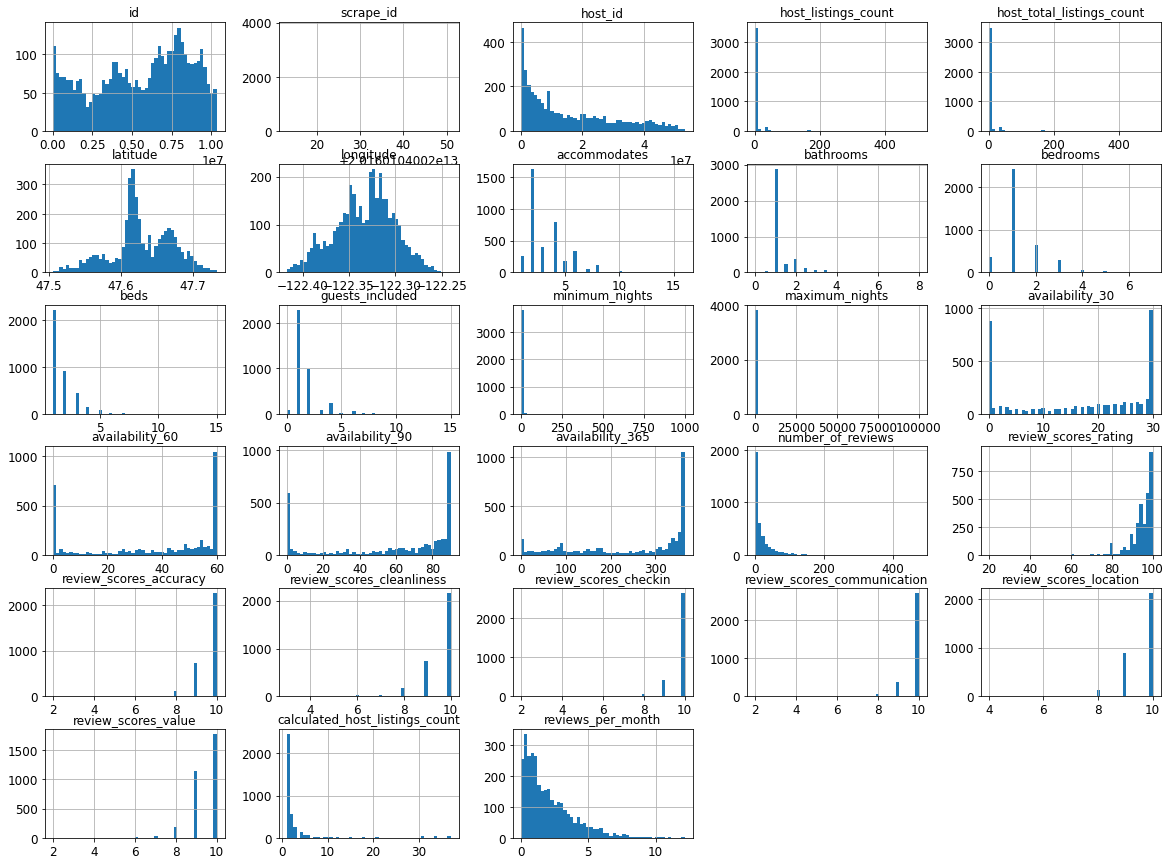

In [31]:
seattle.hist(bins=50, figsize=(20,15))
plt.show()

In [43]:
seattle_train, seattle_test = train_test_split(seattle, test_size=0.2, random_state=42)

3054

764